In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

## Election Results

Election results are from Oklahoma State Election Board (https://www.ok.gov/elections/Election_Info/Election_Results/index.html)

## Shape Files
Precinct shapefile from Oklahoma Data Warehouse (https://data.csa.ou.edu/

RDH note: shapefile for GIS data warehouse here: https://csagis-uok.opendata.arcgis.com/datasets/c83b09af406d48f7bbca30942fe186a8_0/explore?location=35.317799%2C-98.716567%2C8.77

## Processing
Countywide results were distributed for Oklahoma County and Tulsa County, these were divided among the constituent precincts based on the vote reported in each precinct.

## Races

 - G16PRERTRU - Donald Trump (Republican Party)
 - G16PREDCLI - Hillary Clinton (Democratic Party)
 - G16PRELJOH - Gary Johnson (Libertarian Party)

 - G16USSRLAN - James Lankford (Republican Party)
 - G16USSDWOR - Mike Workman (Democratic Party)
 - G16USSLMUR - Robert T. Murphy (Libertarian Party)
 - G16USSIBRA - Mark T. Beard (Independent)
 - G16USSIBEA - Sean Braddy (Independent)

# Precinct Shapefile

In [2]:
vest_shp = gp.read_file("./raw-from-source/ok_2016/ok_2016.shp")

In [3]:
vest_shp.shape

(1956, 12)

In [4]:
vest_shp.head()

,COUNTY,PRECINCT,PCT_CEB,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16USSRLAN,G16USSDWOR,G16USSLMUR,G16USSIBRA,G16USSIBEA,geometry
0,01,1,010001,250,78,27,249,79,11,6,4,"POLYGON ((-94.62595 35.77919, -94.62591 35.777..."
1,01,2,010002,226,62,11,215,63,9,4,1,"POLYGON ((-94.72330 35.79789, -94.72202 35.797..."
2,01,3,010003,96,32,2,93,39,1,1,0,"POLYGON ((-94.72479 36.02797, -94.72449 36.027..."
3,01,5,010005,175,45,13,188,35,2,2,3,"POLYGON ((-94.72595 35.80642, -94.72595 35.806..."
4,01,6,010006,345,92,21,321,109,7,6,13,"POLYGON ((-94.66412 35.90763, -94.66417 35.907..."


<AxesSubplot:>

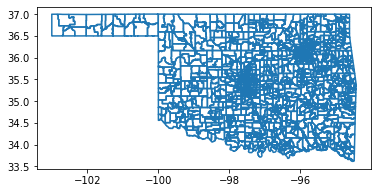

In [5]:
vest_shp.boundary.plot()

<AxesSubplot:>

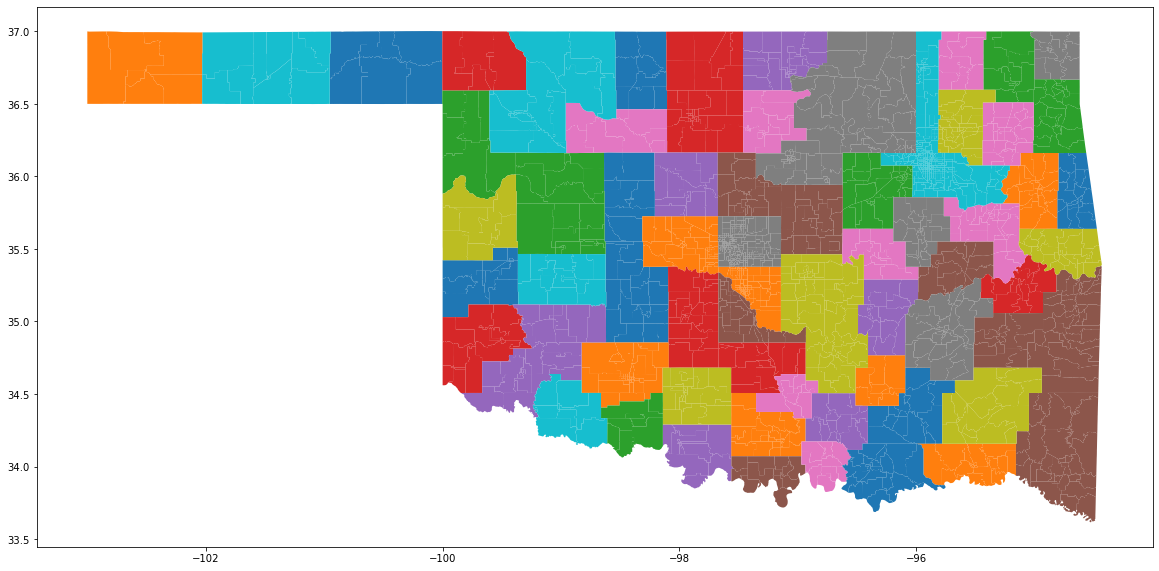

In [6]:
vest_shp.plot(column='COUNTY', figsize=(20,20))

In [7]:
vest_shp.columns

Index(['COUNTY', 'PRECINCT', 'PCT_CEB', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRLAN', 'G16USSDWOR', 'G16USSLMUR', 'G16USSIBRA',
       'G16USSIBEA', 'geometry'],
      dtype='object')

## Load the SOS Election Results File

In [8]:
ok_16 = pd.read_csv("raw-from-source/results/20161108_PrecinctResults.csv", index_col=False)

In [9]:
ok_16.head()

,elec_date,precinct,entity_description,race_number,race_description,race_party,tot_race_prec,race_prec_reporting,cand_number,cand_name,cand_party,cand_absmail_votes,cand_early_votes,cand_elecday_votes,cand_tot_votes,race_county_owner
0,11/8/2016,10001,"FEDERAL, STATE AND COUNTY",10001,FOR PRESIDENT AND VICE PRESIDENT,NaN,1956,1956,1,DONALD J. TRUMP | MICHAEL R. PENCE,REP,9,27,214,250,NaN
1,11/8/2016,10001,"FEDERAL, STATE AND COUNTY",10001,FOR PRESIDENT AND VICE PRESIDENT,NaN,1956,1956,2,GARY JOHNSON | BILL WELD,LIB,4,4,19,27,NaN
2,11/8/2016,10001,"FEDERAL, STATE AND COUNTY",10001,FOR PRESIDENT AND VICE PRESIDENT,NaN,1956,1956,3,HILLARY CLINTON | TIM KAINE,DEM,4,2,72,78,NaN
3,11/8/2016,10001,"FEDERAL, STATE AND COUNTY",10003,FOR UNITED STATES SENATOR,NaN,1956,1956,1,JAMES LANKFORD,REP,13,25,211,249,NaN
4,11/8/2016,10001,"FEDERAL, STATE AND COUNTY",10003,FOR UNITED STATES SENATOR,NaN,1956,1956,2,ROBERT T. MURPHY,LIB,2,1,8,11,NaN


In [10]:
ok_16.shape

(86471, 16)

In [11]:
#filter rows with presidential, Senatorial, and Corporate Commissioner results
filtered_16 = ok_16.loc[(ok_16['race_description']== 'FOR PRESIDENT AND VICE PRESIDENT') 
                        | (ok_16['race_description']== 'FOR UNITED STATES SENATOR')]
filtered_16.reset_index(drop=True, inplace = True)

ok_unq = filtered_16['race_description'].value_counts()
print(ok_unq)


FOR UNITED STATES SENATOR           9790
FOR PRESIDENT AND VICE PRESIDENT    5874
Name: race_description, dtype: int64


In [12]:
#dropping info
filtered_df = filtered_16.drop(['cand_absmail_votes','cand_early_votes','cand_elecday_votes','tot_race_prec','race_prec_reporting','race_county_owner','elec_date','entity_description','race_party','cand_number','cand_party'], axis=1)
filtered_df


,precinct,race_number,race_description,cand_name,cand_tot_votes
0,10001,10001,FOR PRESIDENT AND VICE PRESIDENT,DONALD J. TRUMP | MICHAEL R. PENCE,250
1,10001,10001,FOR PRESIDENT AND VICE PRESIDENT,GARY JOHNSON | BILL WELD,27
2,10001,10001,FOR PRESIDENT AND VICE PRESIDENT,HILLARY CLINTON | TIM KAINE,78
3,10001,10003,FOR UNITED STATES SENATOR,JAMES LANKFORD,249
4,10001,10003,FOR UNITED STATES SENATOR,ROBERT T. MURPHY,11
...,...,...,...,...,...
15659,770307,10003,FOR UNITED STATES SENATOR,JAMES LANKFORD,123
15660,770307,10003,FOR UNITED STATES SENATOR,ROBERT T. MURPHY,2
15661,770307,10003,FOR UNITED STATES SENATOR,MIKE WORKMAN,16
15662,770307,10003,FOR UNITED STATES SENATOR,MARK T. BEARD,3


In [13]:
#pivoting based on cand_name and precinct vote totals
pivot_df = pd.pivot_table(filtered_df, index = 'precinct', columns = 'cand_name', values="cand_tot_votes")
print(pivot_df)

cand_name  DONALD J. TRUMP | MICHAEL R. PENCE  GARY JOHNSON | BILL WELD  \
precinct                                                                  
10001                                     250                        27   
10002                                     226                        11   
10003                                      96                         2   
10004                                     198                        18   
10005                                     175                        13   
...                                       ...                       ...   
770302                                    259                         7   
770303                                      0                         0   
770304                                    191                        11   
770306                                   1258                        60   
770307                                    125                         5   

cand_name  HILLARY CLINT

In [17]:
#dropping and renaming columns to match VEST
pivot_df = pivot_df.rename(columns={'DONALD J. TRUMP | MICHAEL R. PENCE':'G16PRERTRU',
                                    'GARY JOHNSON | BILL WELD':'G16PRELJOH',
                                    'HILLARY CLINTON | TIM KAINE':'G16PREDCLI',
                                    'JAMES LANKFORD':'G16USSRLAN',
                                    'MIKE WORKMAN':'G16USSDWOR',
                                    'ROBERT T. MURPHY':'G16USSLMUR',
                                    'MARK T. BEARD':'G16USSIBEA',
                                    'SEAN BRADDY':'G16USSIBRA'})
pivot_df = pivot_df[['G16PRERTRU', 'G16PREDCLI','G16PRELJOH', 'G16USSRLAN', 'G16USSDWOR', 'G16USSLMUR', 'G16USSIBEA','G16USSIBRA']]
pivot_df.reset_index(inplace=True)
print(pivot_df)

cand_name  precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRLAN  \
0             10001         250          78          27         249   
1             10002         226          62          11         215   
2             10003          96          32           2          93   
3             10004         198          71          18         198   
4             10005         175          45          13         188   
...             ...         ...         ...         ...         ...   
1953         770302         259          25           7         255   
1954         770303           0           0           0           0   
1955         770304         191          21          11         182   
1956         770306        1258         143          60        1274   
1957         770307         125          18           5         123   

cand_name  G16USSDWOR  G16USSLMUR  G16USSIBEA  G16USSIBRA  
0                  79          11           4           6  
1                  63      

In [18]:
#uploading national FIPS codes to apply back to file
FIPS = pd.read_csv('./raw-from-source/US_FIPS_Codes.csv')
FIPS = FIPS[FIPS['State'] == 'Oklahoma']
FIPS1 = FIPS.drop(['State','FIPS State'],axis=1)

#adding leading zeroes to FIPS data
FIPS1['FIPS County'] = FIPS1['FIPS County'].apply(lambda x:'{0:0>3}'.format(x))
FIPS1.reset_index(inplace=True)
FIPS1 = FIPS1.drop(['index'],axis=1)
print(FIPS1)

   County Name FIPS County
0        Adair         001
1      Alfalfa         003
2        Atoka         005
3       Beaver         007
4      Beckham         009
..         ...         ...
72     Wagoner         145
73  Washington         147
74     Washita         149
75       Woods         151
76    Woodward         153

[77 rows x 2 columns]


In [19]:
# changing FIPS county type to str taking first two characters, selecting only the first 162 rows which need to have zeroes removed
df_1 = pivot_df['precinct'].astype(str).str[:2]
df_3 = df_1.iloc[:163]

#replace all trailing zeroes with blank and create new dataframe with FIPS codes
df_2 = []
for string in df_3:
    df_3 = string.replace("0", "")
    df_2.append(df_3)

# rejoining dataframe to itself
df = pd.DataFrame(df_2)
df_append = df_1.iloc[163:]
print(df_append)
dataframes = [df, df_append]
df = pd.concat(dataframes)

163     10
164     10
165     10
166     10
167     10
        ..
1953    77
1954    77
1955    77
1956    77
1957    77
Name: precinct, Length: 1795, dtype: object


In [20]:
# Rename first column, convert county code to national FIPS #, add leading zeroes
df.rename( columns={0 :'FIPS County'}, inplace=True )
df.loc[(df['FIPS County']=='81') ,"FIPS County"] = '8'
print(df)

     FIPS County
0              1
1              1
2              1
3              1
4              1
...          ...
1953          77
1954          77
1955          77
1956          77
1957          77

[1958 rows x 1 columns]


In [21]:
df['FIPS County'] = df.astype(int)*2-1
df['FIPS County'].astype(str).apply(lambda x:'{0:0>3}'.format(x))

0       001
1       001
2       001
3       001
4       001
       ... 
1953    153
1954    153
1955    153
1956    153
1957    153
Name: FIPS County, Length: 1958, dtype: object

In [22]:
pivot_df['FIPS County'] = df['FIPS County'].astype(str).apply(lambda x:'{0:0>3}'.format(x))
print(pivot_df)

cand_name  precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRLAN  \
0             10001         250          78          27         249   
1             10002         226          62          11         215   
2             10003          96          32           2          93   
3             10004         198          71          18         198   
4             10005         175          45          13         188   
...             ...         ...         ...         ...         ...   
1953         770302         259          25           7         255   
1954         770303           0           0           0           0   
1955         770304         191          21          11         182   
1956         770306        1258         143          60        1274   
1957         770307         125          18           5         123   

cand_name  G16USSDWOR  G16USSLMUR  G16USSIBEA  G16USSIBRA FIPS County  
0                  79          11           4           6         001  
1  

In [23]:
#adding FIPS to vest file
pivot_df = pivot_df.merge(FIPS1, how='left', on='FIPS County')

pivot_df

,precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16USSRLAN,G16USSDWOR,G16USSLMUR,G16USSIBEA,G16USSIBRA,FIPS County,County Name
0,10001,250,78,27,249,79,11,4,6,001,Adair
1,10002,226,62,11,215,63,9,1,4,001,Adair
2,10003,96,32,2,93,39,1,0,1,001,Adair
3,10004,198,71,18,198,74,6,5,4,001,Adair
4,10005,175,45,13,188,35,2,3,2,001,Adair
...,...,...,...,...,...,...,...,...,...,...,...
1953,770302,259,25,7,255,22,7,3,2,153,Woodward
1954,770303,0,0,0,0,0,0,0,0,153,Woodward
1955,770304,191,21,11,182,20,10,5,5,153,Woodward
1956,770306,1258,143,60,1274,128,31,11,13,153,Woodward


In [24]:
#modifying FIPS number
vest_shp['COUNTY'] = vest_shp['COUNTY'].astype(int)*2-1
vest_shp['FIPS COUNTY'] = vest_shp['COUNTY'].astype(str).apply(lambda x:'{0:0>3}'.format(x))
print(vest_shp)

      COUNTY PRECINCT PCT_CEB  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRLAN  \
0          1        1  010001         250          78          27         249   
1          1        2  010002         226          62          11         215   
2          1        3  010003          96          32           2          93   
3          1        5  010005         175          45          13         188   
4          1        6  010006         345          92          21         321   
...      ...      ...     ...         ...         ...         ...         ...   
1951     127       16  640016         131          26          10         118   
1952     127       17  640017         153          47           7         128   
1953     127        8  640008         127          29           1         105   
1954     127       14  640014          96           5           7          83   
1955     127        4  640004         390          83          26         358   

      G16USSDWOR  G16USSLMU

## Validate Elections Results

In [25]:
#statewide vote total check
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [26]:
column_list = ['G16PRERTRU', 'G16PREDCLI','G16PRELJOH', 'G16USSRLAN', 'G16USSDWOR', 'G16USSLMUR', 'G16USSIBRA','G16USSIBEA']
statewide_totals_check(vest_shp, pivot_df, column_list)

***Statewide Totals Check***
G16PRERTRU is equal 	VEST / RDH: 949136
G16PREDCLI is equal 	VEST / RDH: 420375
G16PRELJOH is equal 	VEST / RDH: 83481
G16USSRLAN is equal 	VEST / RDH: 980892
G16USSDWOR is equal 	VEST / RDH: 355911
G16USSLMUR is equal 	VEST / RDH: 43421
G16USSIBRA is equal 	VEST / RDH: 40405
G16USSIBEA is equal 	VEST / RDH: 27418


In [27]:
#Allocate Absentee Precincts
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [28]:
# calling function and creating fields not in aggregate Absentee Precincts

absentee_votes = pivot_df[pivot_df["precinct"].isin([559999,729999])]
precinct_votes = pivot_df[~pivot_df["precinct"].isin([559999,729999])]
allocated_df = allocate_absentee(precinct_votes, absentee_votes, column_list,"FIPS County")

C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [29]:
#set to string and set leading zeroes then merge based on ID
vest_shp["unique_ID"] = vest_shp["PCT_CEB"].astype(str)
allocated_df["unique_ID"] = allocated_df["precinct"].astype(str)
allocated_df['unique_ID'] = allocated_df['unique_ID'].astype(str).apply(lambda x:'{0:0>6}'.format(x))
join_1 = pd.merge(allocated_df, vest_shp, how="outer",on='unique_ID', indicator = True, validate="1:1")
join_1["_merge"].value_counts()

<ipython-input-29-cf667081b4d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_df["unique_ID"] = allocated_df["precinct"].astype(str)
<ipython-input-29-cf667081b4d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_df['unique_ID'] = allocated_df['unique_ID'].astype(str).apply(lambda x:'{0:0>6}'.format(x))


both          1956
left_only        0
right_only       0
Name: _merge, dtype: int64

In [30]:
#source_df = our data on the left of the columns - last two characters
source_df = join_1.iloc[:,15:23]
source_df = source_df.rename(columns = lambda x : str(x)[:-2])
print(source_df)
#partner_df = MGGG/VEST data on the right - last two characters
partner_df = join_1.iloc[:,1:9]
partner_df = partner_df.rename(columns = lambda x : str(x)[:-2])
print(partner_df)

      G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRLAN  G16USSDWOR  G16USSLMUR  \
0            250          78          27         249          79          11   
1            226          62          11         215          63           9   
2             96          32           2          93          39           1   
3            198          71          18         198          74           6   
4            175          45          13         188          35           2   
...          ...         ...         ...         ...         ...         ...   
1951         259          25           7         255          22           7   
1952           0           0           0           0           0           0   
1953         191          21          11         182          20          10   
1954        1258         143          60        1274         128          31   
1955         125          18           5         123          16           2   

      G16USSIBRA  G16USSIBEA  
0       

In [31]:
#Checks county level results
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [32]:
#county_col = name of counties needed to compare
county_col = join_1["County Name"]
print(county_col)
county_totals_check(partner_df, source_df,column_list, county_col)

0          Adair
1          Adair
2          Adair
3          Adair
4          Adair
          ...   
1951    Woodward
1952    Woodward
1953    Woodward
1954    Woodward
1955    Woodward
Name: County Name, Length: 1956, dtype: object
***Countywide Totals Check***

G16PRERTRU is equal across all counties
G16PREDCLI is equal across all counties
G16PRELJOH is equal across all counties
G16USSRLAN is equal across all counties
G16USSDWOR is equal across all counties
G16USSLMUR is equal across all counties
G16USSIBRA is equal across all counties
G16USSIBEA is equal across all counties


In [33]:
#Checks individual precinct level
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [34]:
#vest_on_left = boolean logic which is TRUE if VEST/MGGG data is on left side of columns FALSE if VEST/MGGG data is on right
merged_df = join_1
vest_on_left = False
#name_col literally the column header with the precinct names without a dataframe
name_col = 'precinct'
precinct_votes_check(merged_df, column_list, vest_on_left, name_col)


There are  1956  total rows
0  of these rows have election result differences
1956  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]
